In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, NullFormatter, ScalarFormatter
import numpy as np
import pandas as pd
import seaborn as sb
import seaborn.objects as so
threads = [1, 2, 4, 8, 16, 32]

df = pd.read_csv("results/julia_benchmark.csv", skip_blank_lines=True)
names = [
    "Median Assembly Time, GC Time Excluded",
    "Mean Assembly Time, GC Time Included",
    "Median Assembly, GC Time Included",
]
cpp_marker = {"LDC-S": "$S$", "LDC-M": "$M$", "Wind": "$W$"}
case_color = {"LDC-S": 'b', "LDC-M": 'g', "Wind": 'r'}
method_color = {"CellBasedAssembly": 'b', "FaceBasedAssembly": 'g', "BatchedFaceBasedAssembly": 'r'}
ax_mapping = {1: {"incl_gc": False, "metric": "median"},2: {"incl_gc": False, "metric": "mean"}, 3: {"incl_gc": True, "metric": "mean"}, 4: {"incl_gc": True, "metric": "median"}}
x = np.arange(1, 7)
xlabels = [str(t) for t in threads]

ylims = [[0, 1200], [0, 2000], [0, 1200]]


In [2]:
cases = df["case_short"].unique()
cases_long = df.groupby("case_long")["case_short"].unique()

In [44]:
serial = pd.read_csv("results/serialOnly.csv")
assemblyMethods = serial["algorithm"].unique()
nCells = {"LDC-S": 1030301, "LDC-M": 8120601, "Wind": 6517376}
metrics = [(False, "mean"), (False, "median"), (True, "mean"), (True, "median")] # (incl_gc, metric)

In [4]:
yticks = [50, 75, 100, 150, 214, 300,500, 750, 1100, 1500, 2100]
ylabels=[f"{y}ms" for y in yticks]

In [29]:
df = serial.copy()
assemblyMethods

array(['CellBasedAssembly', 'FaceBasedAssembly',
       'BatchedFaceBasedAssembly', 'C++ CellBasedAssembly',
       'C++ FaceBasedAssembly', 'C++ BatchedFaceBasedAssembly'],
      dtype=object)

In [30]:
from math import log10, floor
nonzeros = {"LDC-S": 6_940_000, "LDC-M": 55_760_000, "Wind": 44_118_270}
cpp = {"LDC-S": 6_940_000, "LDC-M": 55_760_000, "Wind": 44_118_270}
normd = []
for ms, case in zip(df["time_ms"], df["case_short"]):
    normd.append(ms / nonzeros[case])
df["time_ms_nnz_normed"] = normd
norm2 = []
for ms, case in zip(df["time_ms"], df["case_short"]):
    norm2.append(ms / nCells[case])
df["time_ms_nCells_normed"] = norm2

In [31]:
joined = []
for a,b in zip(df["incl_gc"], df["metric"]):
    incl = "Inclusive GC" if a else "Exclusive GC"
    joined.append(f"{incl}, {b}")
df["gc_metric_joined"] = joined

['CellBasedAssembly', 'FaceBasedAssembly', 'BatchedFaceBasedAssembly', 'C++ CellBasedAssembly', 'C++ FaceBasedAssembly', 'C++ BatchedFaceBasedAssembly', 'C++ CellBasedAssembly']
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>


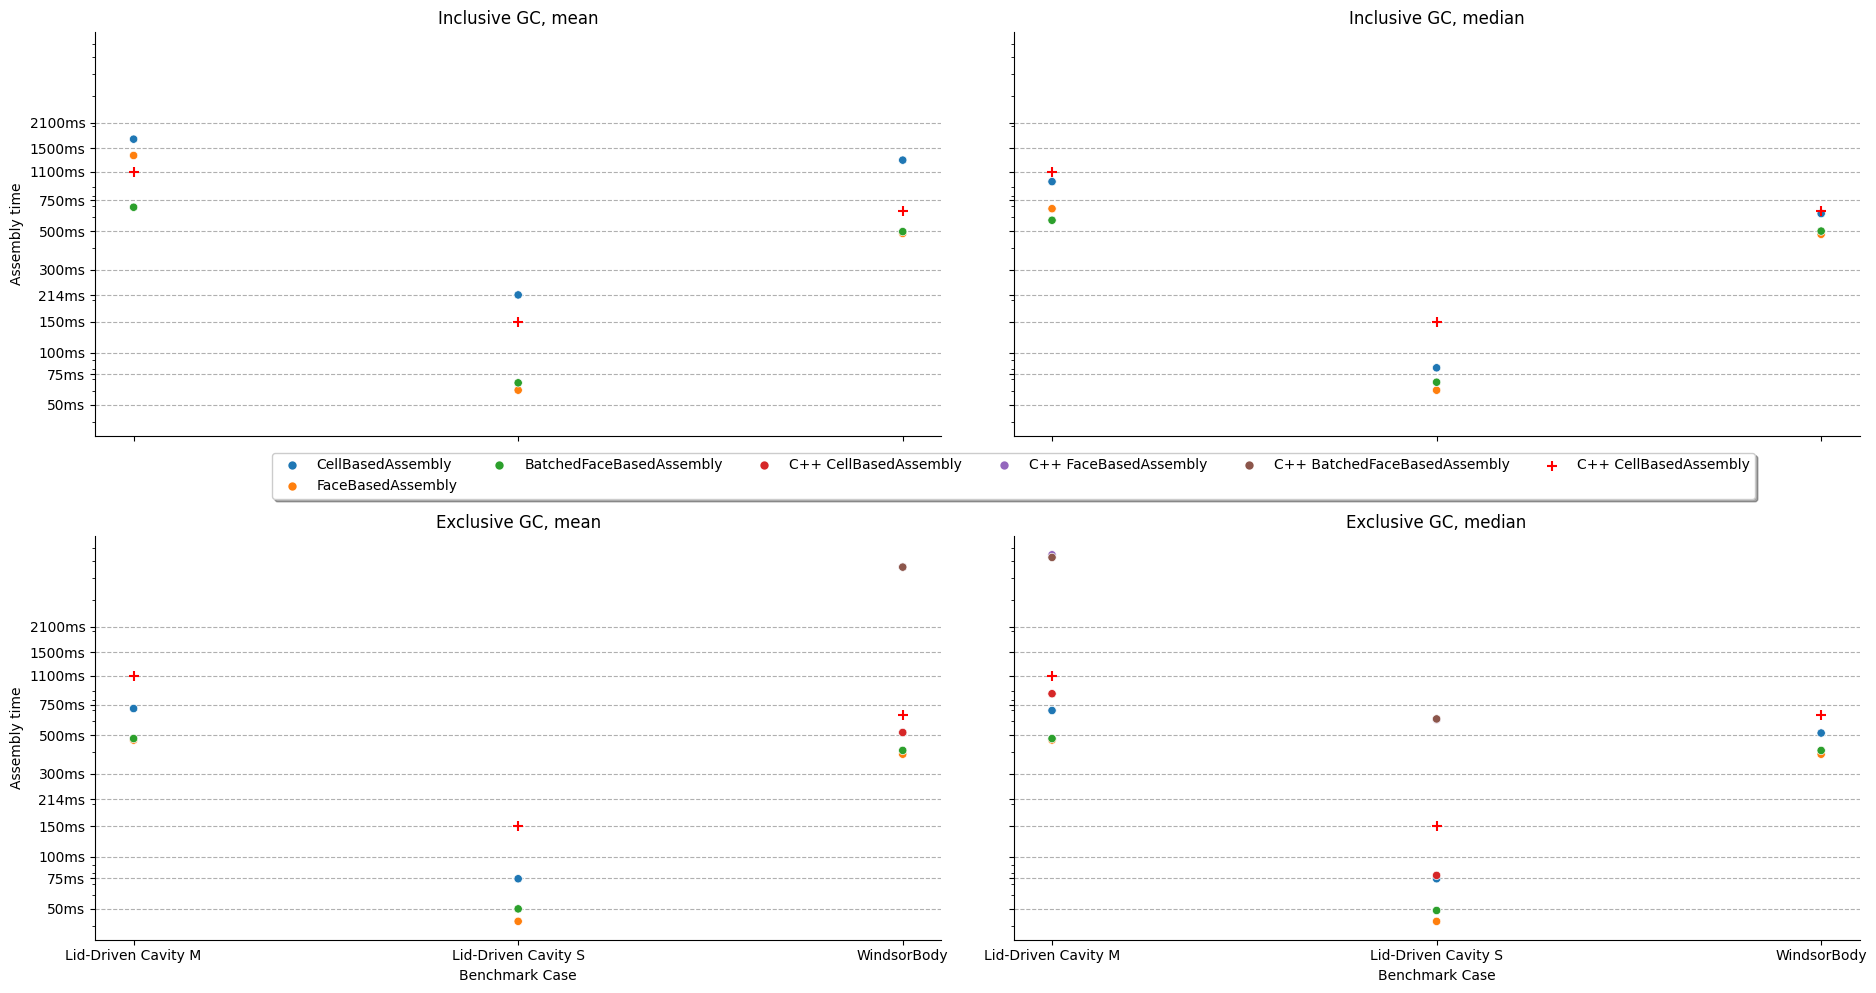

In [ ]:
p = sb.relplot(data=df, x='case_long', y='time_ms', hue='algorithm', hue_order=assemblyMethods, aspect=1.61, col="gc_metric_joined", col_wrap=2)
axes = p.axes.flat
labels = axes[0].get_legend_handles_labels()[1]
labels.append("C++ CellBasedAssembly")
print(labels)
for ax in axes:
    ax.scatter([0], 1100, marker='+', color='r', label=f"C++ CellBasedAssembly", s=60)
    ax.scatter([1], 150, marker='+', color='r', s=60)
    ax.scatter([2], 650, marker='+', color='r', s=60)

    ax.set_ylabel("Assembly time")
    ax.set_xlabel("Benchmark Case")
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.yaxis.grid(True, linestyle="dashed")
    ax.set_title(ax.title.get_text().split(" = ")[1])
    ax.set_axisbelow(True) # so that markers are drawn on top of the grid
p.legend.remove()
for t, new_label in zip(p.legend.texts, labels):
    print(type(t))
    t.set_text(new_label)
handles, labels = axes[0].get_legend_handles_labels()
plt.subplots_adjust(hspace=0.25, right=0.98)
plt.legend(handles, labels, loc="center", bbox_to_anchor = (-0,1.15),ncol=6, fancybox=True, shadow=True)
# p.fig.suptitle("Serial Matrix Assembly", fontsize=22, horizontalalignment="center")
plt.savefig("figures/assembly.svg")


0.0007829684830213877 3.70469900501804e-05
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>


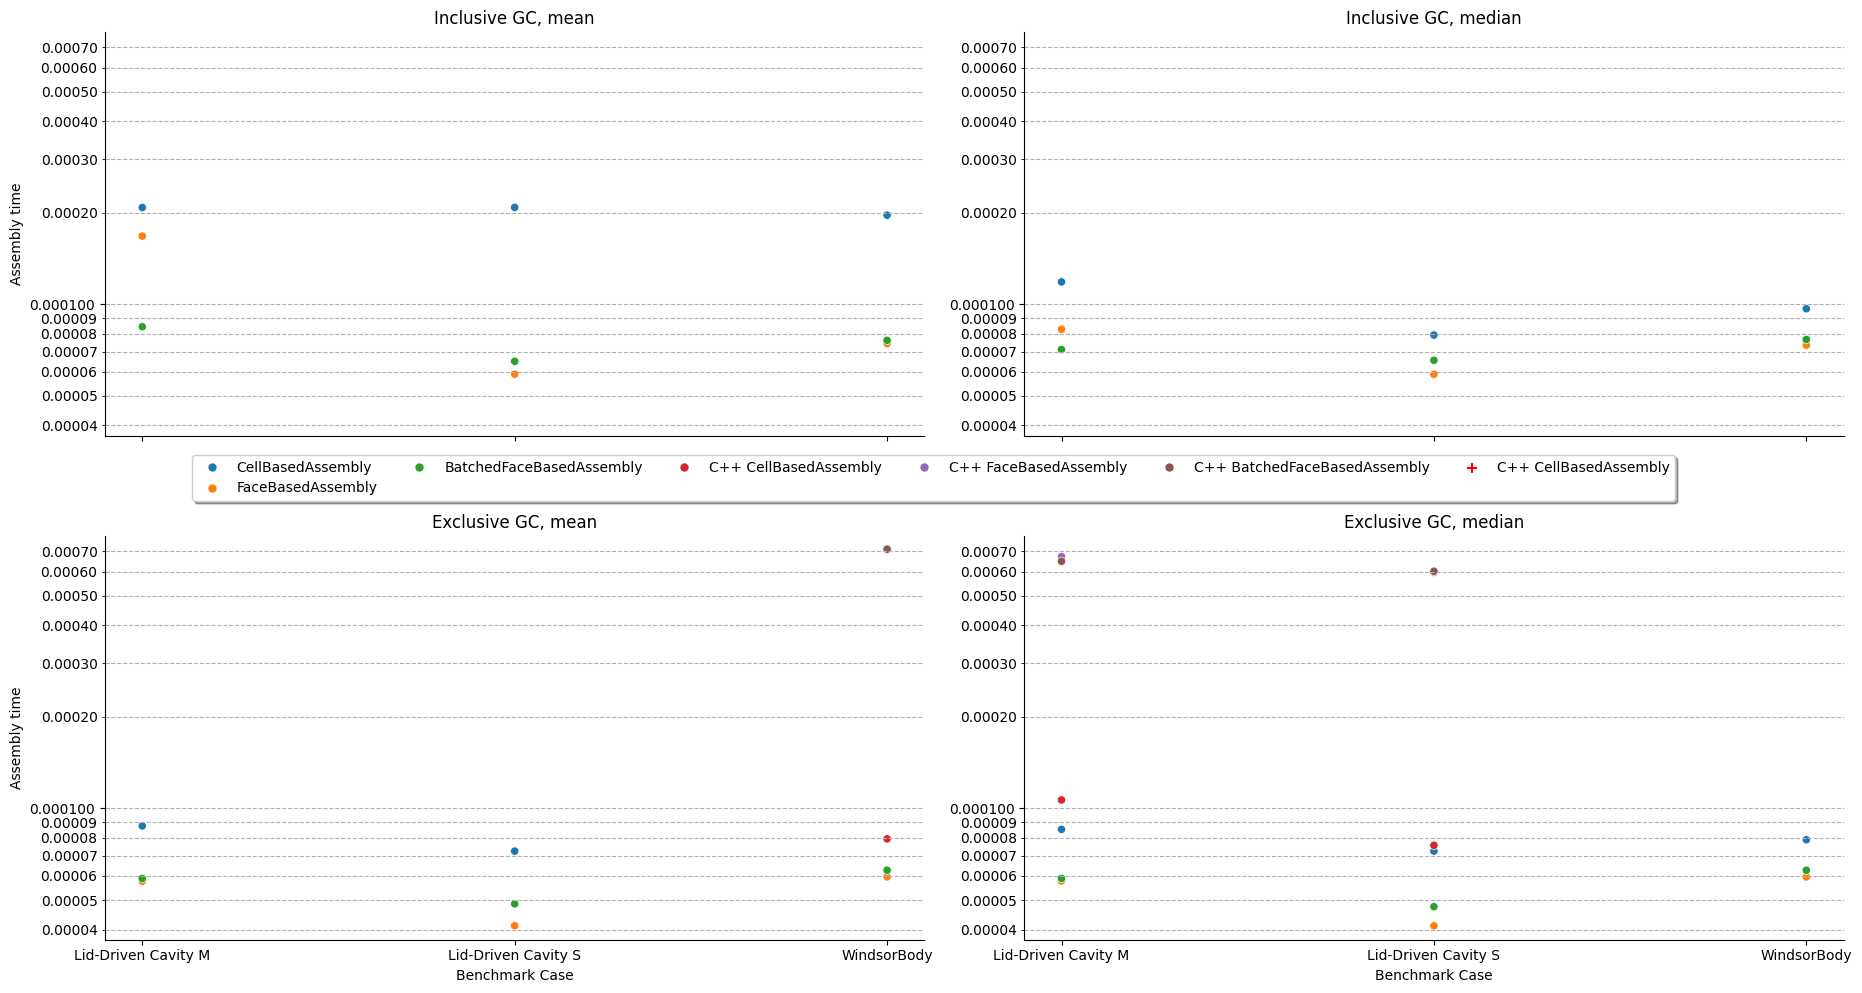

In [ ]:
p = sb.relplot(
    data=df, 
    x='case_long', 
    y='time_ms_nCells_normed', 
    hue='algorithm', 
    hue_order=assemblyMethods, 
    aspect=1.61, 
    col="gc_metric_joined", 
    col_wrap=2, 
    facet_kws={'sharey': False, 'sharex': True},
)
m = max(df["time_ms_nCells_normed"])
n = min(df["time_ms_nCells_normed"])
print(m + m/10, n - n/10)
for i, ax in enumerate(p.axes.flat):
    if i % 2 == 0:
        ax.set_ylabel("Assembly time")
    ax.scatter([0], 1100/ nonzeros["LDC-M"], marker='+', color='r', label=f"C++ CellBasedAssembly", s=60)
    ax.scatter([1], 150/ nonzeros["LDC-S"], marker='+', color='r', s=60)
    ax.scatter([2], 650/ nonzeros["Wind"], marker='+', color='r', s=60)
    ax.yaxis.grid(True, linestyle="dashed", which="both")
    ax.set_xlabel("Benchmark Case")
    ax.set_yscale("log")
    ax.set_ylim([n-n/10,m+m/10])
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.yaxis.minorticks_on()
    ax.set_title(ax.title.get_text().split(" = ")[1])
p.legend.remove()
for t, new_label in zip(p.legend.texts, labels):
    print(type(t))
    t.set_text(new_label)
handles, labels = p.fig.axes[0].get_legend_handles_labels()
plt.subplots_adjust(hspace=0.25, right=0.98)
p.fig.legend(handles, labels, loc="center", bbox_to_anchor = (0.5,0.52),ncol=6, fancybox=True, shadow=True)
# p.fig.suptitle("Serial Matrix Assembly,  Normed by #Non-Zero Elements", fontsize=22, horizontalalignment="center")
# plt.show()
plt.savefig("figures/assembly_normed_ncells.svg")

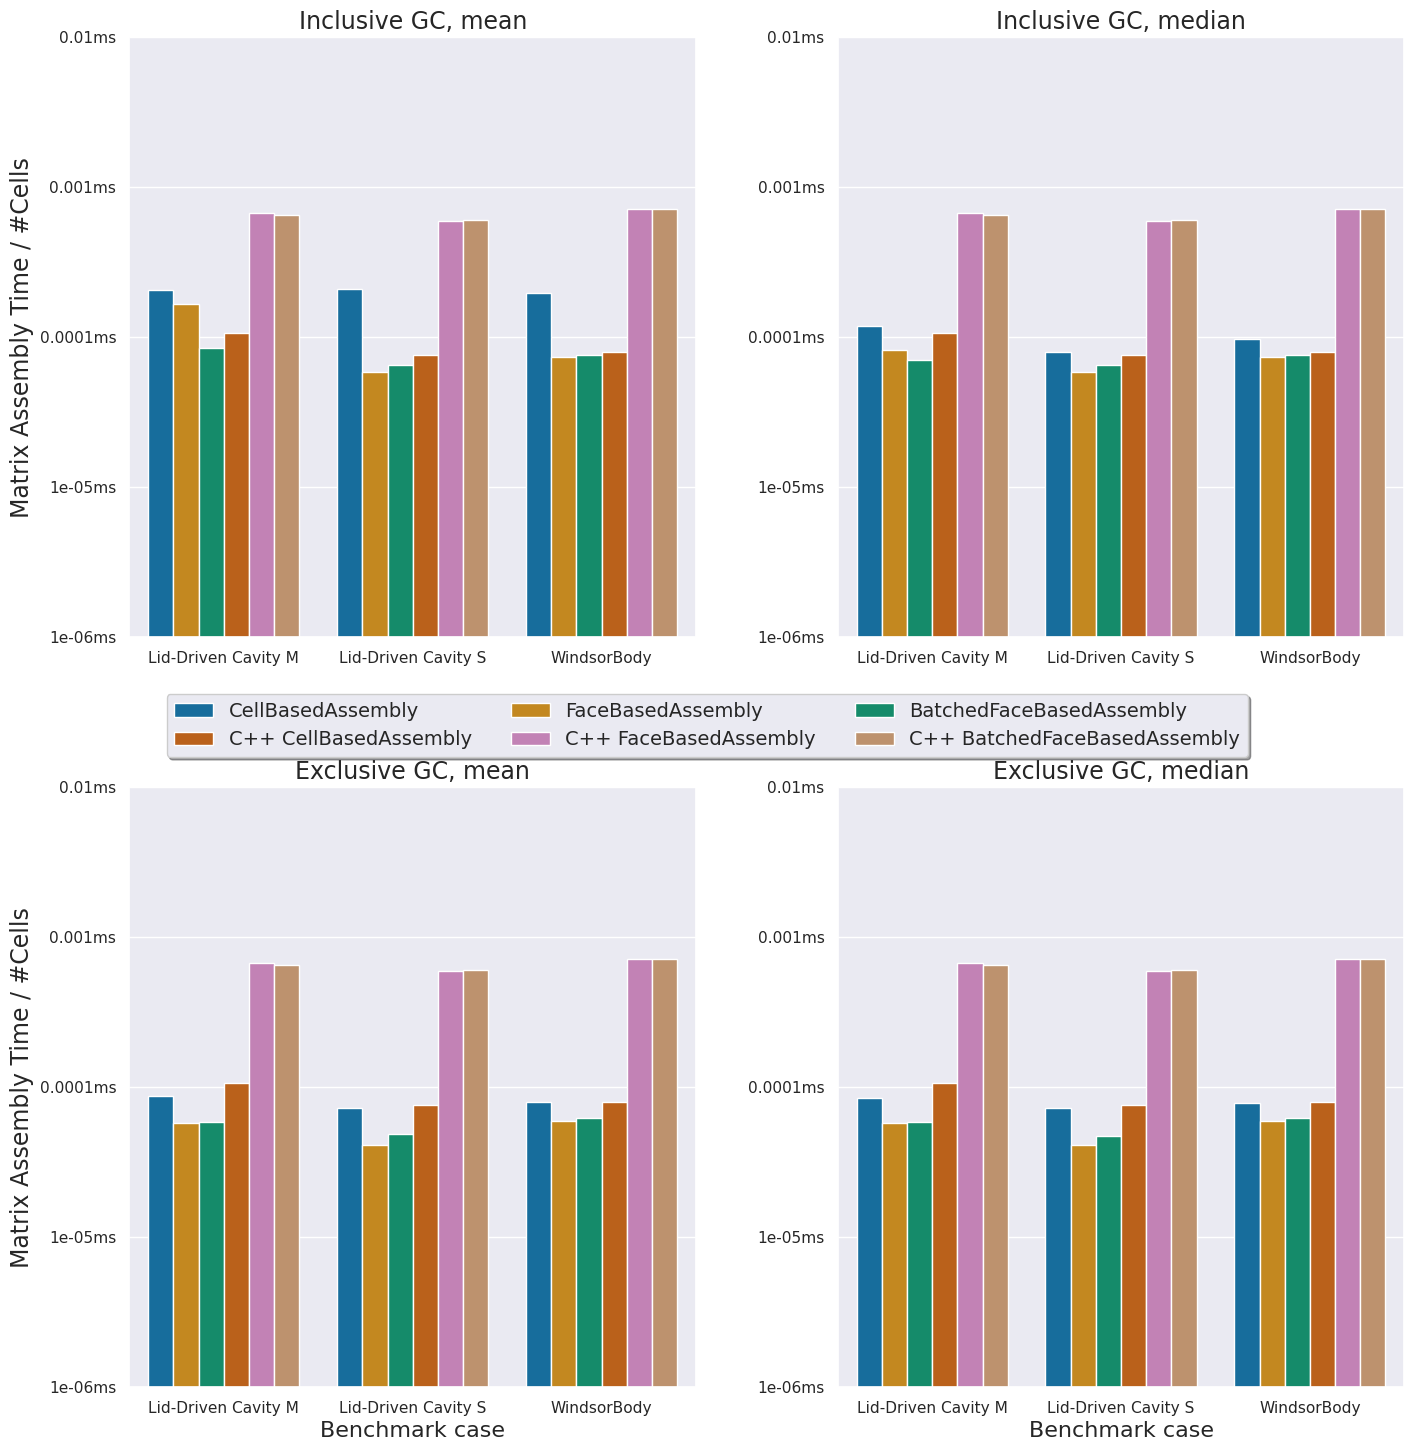

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15, 15))
m = max(df["time_ms_nCells_normed"])
n = min(df["time_ms_nCells_normed"])
i = 0
sb.set(font_scale = 1.005)
for ax, metric in zip(axes.flat, df["gc_metric_joined"].unique()):
    mdf = df[df["gc_metric_joined"]==metric]
    sb.barplot(
        data=mdf, 
        x='case_long', 
        y='time_ms_nCells_normed', 
        hue='algorithm', 
        hue_order=assemblyMethods, 
        ax=ax,
        palette="colorblind"
    )
    if i % 2 == 0:
        ax.set_ylabel("Matrix Assembly Time / #Cells", fontsize=17)
    else:
        ax.set_ylabel("")
    if i < 2:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Benchmark case", fontsize=16)
    ax.set_ylim([n-n/10,m+m/10])
    ax.set_yscale("log")

    ax.yaxis.set_major_formatter(ScalarFormatter())
    yticks = [y for y in ax.get_yticks()]
    ylabels=[f"{y}ms" for y in yticks]
    ax.yaxis.set_ticks(yticks)
    ax.yaxis.set_ticklabels(ylabels)
    ax.set_title(metric, fontsize=17)
    i += 1

handles, labels = axes.flat[0].get_legend_handles_labels()
for ax in axes.flat:
    ax.legend().remove()
labels = [item for pair in zip(labels[:3], labels[3:]) for item in pair]
handles = [item for pair in zip(handles[:3], handles[3:]) for item in pair]
plt.subplots_adjust(hspace=0.25,wspace=0.25, top=0.95, bottom=0.05,left=0.1, right=0.95)
fig.legend(handles, labels, loc="center",ncol=3, fancybox=True, shadow=True,fontsize=14)
plt.savefig("figures/assembly_normed_ncells.svg")

['CellBasedAssembly', 'FaceBasedAssembly', 'BatchedFaceBasedAssembly', 'C++ CellBasedAssembly', 'C++ FaceBasedAssembly', 'C++ BatchedFaceBasedAssembly']


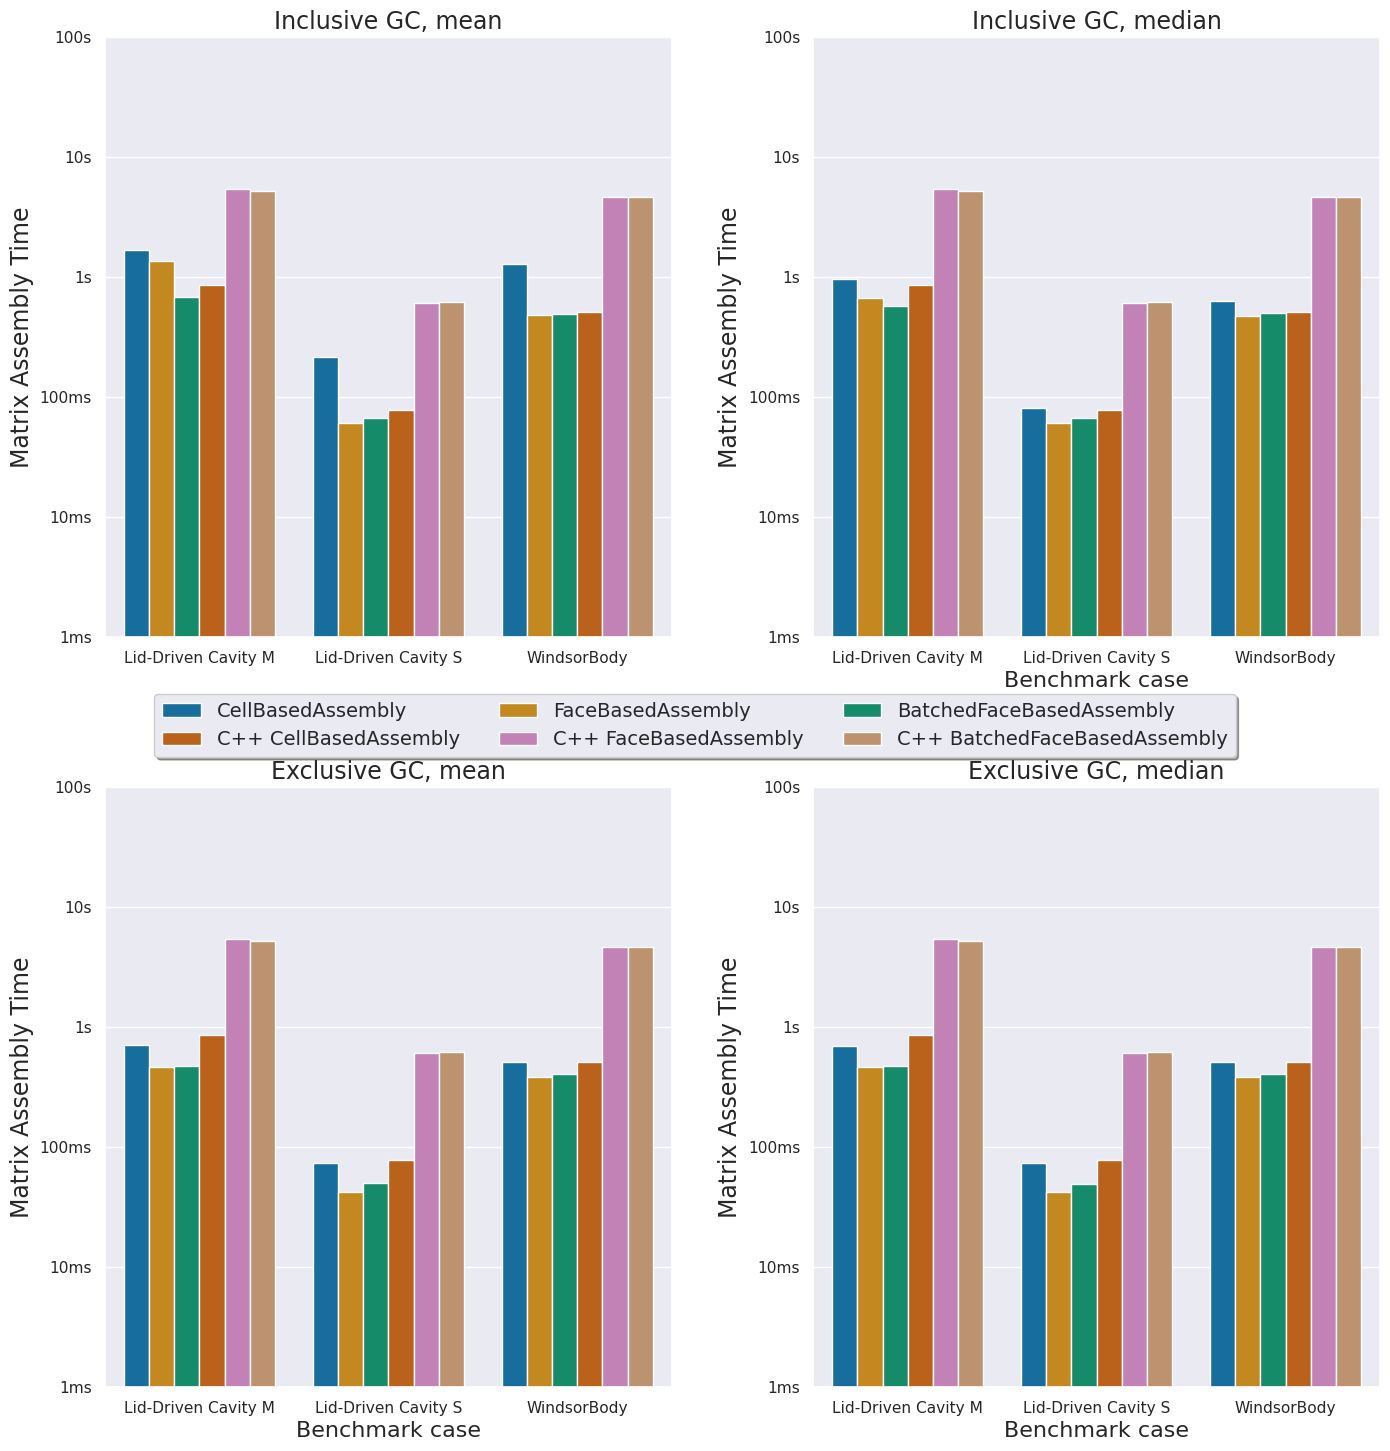

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15, 15))
m = max(df["time_ms"])
n = min(df["time_ms"])
i = 0
sb.set(font_scale = 1.005)

for ax, metric in zip(axes.flat, df["gc_metric_joined"].unique()):
    mdf = df[df["gc_metric_joined"]==metric]
    sb.barplot(
        data=mdf, 
        x='case_long', 
        y='time_ms', 
        hue='algorithm', 
        hue_order=assemblyMethods, 
        ax=ax,
        palette="colorblind"
    )
    if i % 2 == 0:
        ax.set_ylabel("Matrix Assembly Time", fontsize=17)
    else:
        ax.set_ylabel("")
    if i < 2:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Benchmark case", fontsize=16)
    ax.set_ylim([n-n/10,m+m/10])
    ax.set_yscale("log")

    ax.yaxis.set_major_formatter(ScalarFormatter())
    yticks = [int(y) for y in ax.get_yticks()]
    ylabels = ["" for _ in range(len(yticks))]
    for i in range(len(yticks)):
        if yticks[i] == 1000:
            ylabels[i] = "1s"
        elif yticks[i] == 10000:
            ylabels[i] = "10s"
        elif yticks[i] == 100000:
            ylabels[i] = "100s"
        else:
            ylabels[i] = f"{yticks[i]}ms"
    ax.yaxis.set_ticks(yticks)
    ax.yaxis.set_ticklabels(ylabels)
    ax.set_title(metric, fontsize=17)
    i += 1
handles, labels = axes.flat[0].get_legend_handles_labels()
for ax in axes.flat:
    ax.legend().remove()
print(labels)
labels = [item for pair in zip(labels[:3], labels[3:]) for item in pair]
handles = [item for pair in zip(handles[:3], handles[3:]) for item in pair]
plt.subplots_adjust(hspace=0.25,wspace=0.25, top=0.95, bottom=0.05,left=0.1, right=0.95)
fig.legend(handles, labels, loc="center",ncol=3, fancybox=True, shadow=True,fontsize=14)
plt.savefig("figures/assembly.svg")

In [54]:
memory_df = pd.read_csv("results/memory.csv")
memory_df

,algorithm,memory,case,case_long
0,CellBasedAssembly,152,LDC-S,Lid-Driven Cavity S
1,CellBasedAssembly,943,Wind,WindsorBody
2,CellBasedAssembly,1160,LDC-M,Lid-Driven Cavity M
3,FaceBasedAssembly,227,LDC-S,Lid-Driven Cavity S
4,FaceBasedAssembly,1440,Wind,WindsorBody
5,FaceBasedAssembly,1810,LDC-M,Lid-Driven Cavity M
6,BatchedFaceBasedAssembly,243,LDC-S,Lid-Driven Cavity S
7,BatchedFaceBasedAssembly,1470,Wind,WindsorBody
8,BatchedFaceBasedAssembly,1850,LDC-M,Lid-Driven Cavity M


In [72]:
from math import log10, floor
normd = []
for mem, case in zip(memory_df["memory"], memory_df["case"]):
    normd.append(mem*1000000 / nCells[case])
memory_df["memory_normed_ncells"] = normd


In [46]:
nCells

{'LDC-S': 1030301, 'LDC-M': 8120601, 'Wind': 6517376}

['CellBasedAssembly', 'FaceBasedAssembly', 'BatchedFaceBasedAssembly']


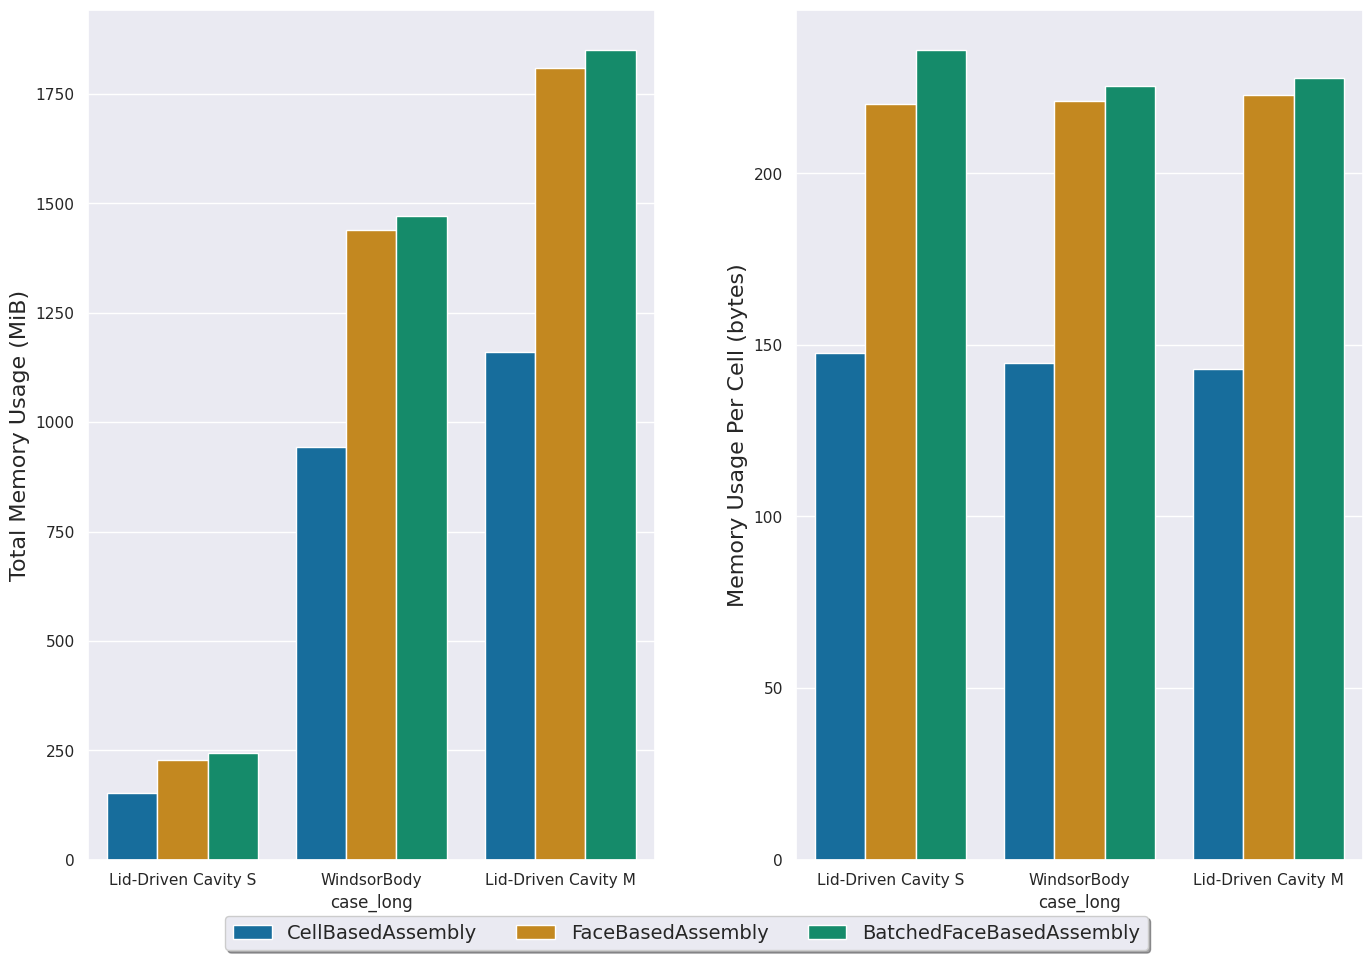

In [83]:
fig, axes = plt.subplots(1,2, figsize=(15, 10))
left = axes.flat[0]
right = axes.flat[1]
sb.set(font_scale = 1.005)

l = sb.barplot(
    data=memory_df, 
    x='case_long', 
    y='memory', 
    hue='algorithm', 
    palette="colorblind",
    ax=left
)

r = sb.barplot(
    data=memory_df, 
    x='case_long', 
    y='memory_normed_ncells', 
    hue='algorithm', 
    palette="colorblind",
    ax=right
)

# l.set_title("Total Memory Usage (MiB)", fontsize=16)
l.set_ylabel("Total Memory Usage (MiB)", fontsize=16)
# l.set_xlabel("Benchmark Case", fontsize=16)

# r.set_title("Bytes Per Cell", fontsize=16)
r.set_ylabel("Memory Usage Per Cell (bytes)", fontsize=16)
# r.set_xlabel("Benchmark Case", fontsize=16)


handles, labels = axes.flat[0].get_legend_handles_labels()
for ax in axes.flat:
    ax.legend().remove()
print(labels)
plt.subplots_adjust(hspace=0.25,wspace=0.25, top=0.95, bottom=0.1,left=0.1, right=0.95)
fig.legend(handles, labels, loc="lower center",ncol=3, fancybox=True, shadow=True,fontsize=14)
plt.savefig("figures/memory_julia.svg")
